In [33]:
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse import linalg
from numpy import matlib
import math
import matplotlib.pyplot as plt

set parameters

In [9]:
gamma = -2 #0 if under log utility
dt = 5
nz = 100
nx = 400
#alpha = 0.01;
#theta = 0.01;
# transaction cost to be zero
alpha = 0#0.01;
theta = 0#0.01;
tau = 0.35
r = 0.01
beta=0.01
mu = 0.07
sigma = 0.25
zlow = 0
zup = 1
xlow = 0
#xup=5
#xup = 1+(alpha+theta)/tau
xup=4
PN = 1e8
tol = 1e-7
dz = (zup-zlow)/nz
dx = (xup-xlow)/nx
dzz = dz*dz
dxx = dx*dx
dxz = dx*dz
nz = nz+1
nx = nx+1
l = nz*nx#number of nodes
sgs = sigma**2

set coefficients

In [10]:
z1=np.arange(zlow,zup+dz,dz)
z=matlib.repmat(z1,1,nx)
z=z.transpose()
x=np.array([])
for i in np.arange(xlow,xup+dx,dx):
    x=np.append(x,i*np.ones(nz))
x=np.expand_dims(x,axis=1)
f=np.ones([l,1])
zs=np.array(z*(1-z))
zt=np.array(z**2)
zh=np.array((1-z)**2)
xs =np.array(x**2)
#invdt=1/dt;
invdt=0;
xz =np.array(x*z*(1-z))

Terminal Condition

In [18]:
#Merton=(mu-r)/sigma^2/(1-gamma)
bb=(beta-gamma*r-gamma*(mu-r)**2/2/(1-gamma)/sigma**2)/(1-gamma)
bb0=(beta-gamma*r-gamma*(mu-r/(1-tau))**2/2/(1-gamma)/sigma**2)/(1-gamma)
#Ms=bb^(-1+gamma)/gamma;
#u=np.log(1-(alpha+tau-tau*x)*(1-z))
#u=math.log(bb**(-1+gamma))/gamma*np.ones([l,1])
u=-6.25*np.ones([l,1])

coefficients in the Lv operator and for inner points

In [15]:
coef1ij0 = np.zeros([l,1])
coef1i1j = np.zeros([l,1])
coefi0j0 = np.zeros([l,1])
coefi0j1 = np.zeros([l,1])
coefi01j = np.zeros([l,1])
coefi1j0 = np.zeros([l,1])
coefi1j1 = np.zeros([l,1])
pos=np.array([],dtype=np.int)#positions of the inner points
for i in range(nx-2):
    idxstart=(i+1)*nz+1
    idxend=(i+2)*nz-1
    pos=np.append(pos,np.arange(idxstart,idxend))
for i in pos:
    coefi1j0[i,0] = -1*(((mu-r-sgs*(1-gamma)+sgs*z[i,0])*zs[i,0]-gamma*sgs*zs[i,0]*z[i,0])<0)*((mu-r-sgs*(1-gamma)+sgs*z[i,0])*zs[i,0]-gamma*sgs*zs[i,0]*z[i,0])/dz+sgs*zs[i,0]*zs[i,0]/dzz/2-sgs*xz[i,0]/dxz/2
for i in pos:
    coef1ij0[i,0] =  (((mu-r-sgs*(1-gamma)+sgs*z[i,0])*zs[i,0]-gamma*sgs*zs[i,0]*z[i,0])>0)*((mu-r-sgs*(1-gamma)+sgs*z[i,0])*zs[i,0]-gamma*sgs*zs[i,0]*z[i,0])/dz+sgs*zs[i,0]*zs[i,0]/dzz/2-sgs*xz[i,0]/dxz/2
for i in pos:
    coefi0j1[i,0] = -1*((mu-sgs*(1-gamma)-gamma*sgs*z[i,0])<0)*(mu-sgs*(1-gamma)-gamma*sgs*z[i,0])*x[i,0]/dx+sgs*xs[i,0]/dxx/2-sgs*xz[i,0]/dxz/2
for i in pos:
    coefi01j[i,0] =  ((mu-sgs*(1-gamma)-gamma*sgs*z[i,0])>0)*(mu-sgs*(1-gamma)-gamma*sgs*z[i,0])*x[i,0]/dx +sgs*xs[i,0]/dxx/2-sgs*xz[i,0]/dxz/2
for i in pos:
    coefi1j1[i,0] = sgs*xz[i,0]/dxz/2
    coef1i1j[i,0] = coefi1j1[i,0]
for i in pos:
    coefi0j0[i,0]= -1*invdt -coefi1j0[i,0]-coef1ij0[i,0]-coefi0j1[i,0]-coefi01j[i,0]-coefi1j1[i,0]-coef1i1j[i,0]

Iteration

In [20]:
count=0
while True:
    count=count+1
    uold=u
    unew=u
    Ibuy = np.zeros([l,1]) #indicator, 1 is in buy region.
    Isell = np.zeros([l,1])
    ncoefi0j0 = np.zeros([l,1])
    ncoefi0j1 = np.zeros([l,1])
    ncoefi01j = np.zeros([l,1])
    ncoefi1j0 = np.zeros([l,1])
    ncoef1ij0 = np.zeros([l,1])
    inner_pos=np.array([],dtype=int)#inner points position
    for i in range(nx-2):
        idxstart=(i+1)*nz+1
        idxend=(i+2)*nz-1
        inner_pos=np.append(inner_pos,np.arange(idxstart,idxend))
#Newton iteration
    ztemp1=(u[inner_pos,0]-u[inner_pos-1,0])/dz
    ztemp2=(u[inner_pos+1,0]-u[inner_pos,0])/dz
    xtemp1=(u[inner_pos,0]-u[inner_pos-nz,0])/dx
    xtemp2=(u[inner_pos+nz,0]-u[inner_pos,0])/dx
    consum_root=np.exp(u[inner_pos,0])*(1+(1-z[inner_pos,0])*ztemp2)
    consum=np.sign(consum_root)*(np.abs(consum_root))**(-1/(1-gamma))
    ncoef1ij0[inner_pos,0] =-1*(gamma<0)*gamma*sgs*(zs[inner_pos,0]*zs[inner_pos,0]*ztemp1+xz[inner_pos,0]*xtemp1)/dz+consum*np.exp(u[inner_pos,0])*(1-z[inner_pos,0])/dz
    ncoefi1j0[inner_pos,0] = (gamma>0)*gamma*sgs*(zs[inner_pos,0]*zs[inner_pos,0]*ztemp2+xz[inner_pos,0]*xtemp2)/dz
    ncoefi01j[inner_pos,0] =-1*(gamma<0)*gamma*sgs*(xs[inner_pos,0]*xtemp1+xz[inner_pos,0]*ztemp1)/dx
    ncoefi0j1[inner_pos,0]=(gamma>0)*gamma*sgs*(xs[inner_pos,0]*xtemp2+xz[inner_pos,0]*ztemp2)/dx
    ncoefi0j0[inner_pos,0]=  -1*np.sign(consum)*np.abs(consum)**gamma
    buytemp = -1*((1+theta*(1-z[inner_pos,0]))*(1-z[inner_pos,0]))*ztemp1 +((1-x[inner_pos,0])>0)*(1-x[inner_pos,0])*xtemp2+((1-x[inner_pos,0])<0)*(1-x[inner_pos,0])*xtemp1 -theta*(1-z[inner_pos,0])
    selltemp = ((-1*alpha-tau+tau*x[inner_pos,0])*zh[inner_pos,0]+(1-z[inner_pos,0]))*ztemp2 - (alpha+tau-tau*x[inner_pos,0])*(1-z[inner_pos,0])
    Ibuy[inner_pos,0]=buytemp>0
    Isell[inner_pos,0]=selltemp>0
    f[inner_pos,0] = -1*unew[inner_pos,0]*invdt-r-(1-z[inner_pos,0])*(mu-r-(1-gamma)/2*sgs*(1-z[inner_pos,0]))+beta/gamma-1/gamma*np.sign(consum)*np.abs(consum)**gamma+consum*np.exp(u[inner_pos,0])-np.sign(consum)*np.abs(consum)**gamma*u[inner_pos,0]+PN*Ibuy[inner_pos,0]*theta*(1-z[inner_pos,0]) + PN*Isell[inner_pos,0]*(alpha+tau-tau*x[inner_pos,0])*(1-z[inner_pos,0])+(gamma<0)*gamma*sgs*(zs[inner_pos,0]/2*zs[inner_pos,0]*ztemp1**2 + xs[inner_pos,0]/2*xtemp1**2+xz[inner_pos,0]*ztemp1*xtemp1)+(gamma>0)*gamma*sgs*(zs[inner_pos,0]/2*zs[inner_pos,0]*ztemp2**2 + xs[inner_pos,0]/2*xtemp2**2+xz[inner_pos,0]*ztemp2*xtemp2)
    #z = zlow; z=zlow&x=xlow at position [0:nx-1]*nz+1
    pos_zlxl = np.arange(0,nx-1)*nz
    Isell[pos_zlxl,0] = 1
    f[pos_zlxl,0] = PN*Isell[pos_zlxl,0]*(alpha+tau-tau*x[pos_zlxl,0])*(1-z[pos_zlxl,0])
     #x = xlow at position [2:nz-1]
    pos_xl = np.arange(1,nz-1)
    coefi1j0[pos_xl,0] = -1*(((mu-r-sgs*(1-gamma)+sgs*z[pos_xl,0])*zs[pos_xl,0]-gamma*sgs*zs[pos_xl,0]*z[pos_xl,0])<0)*((mu-r-sgs*(1-gamma)+sgs*z[pos_xl,0])*zs[pos_xl,0]-gamma*sgs*zs[pos_xl,0]*z[pos_xl,0])/dz + sgs*zs[pos_xl,0]*zs[pos_xl,0]/dzz/2
    coef1ij0[pos_xl,0] =  (((mu-r-sgs*(1-gamma)+sgs*z[pos_xl,0])*zs[pos_xl,0]-gamma*sgs*zs[pos_xl,0]*z[pos_xl,0])>0)*((mu-r-sgs*(1-gamma)+sgs*z[pos_xl,0])*zs[pos_xl,0]-gamma*sgs*zs[pos_xl,0]*z[pos_xl,0])/dz+ sgs*zs[pos_xl,0]*zs[pos_xl,0]/dzz/2
    coefi0j0[pos_xl,0] = -1*invdt - coefi1j0[pos_xl,0] - coef1ij0[pos_xl,0]
    ztemp1 = (u[pos_xl,0]-u[pos_xl-1,0])/dz
    ztemp2 = (u[pos_xl+1,0]-u[pos_xl,0])/dz
    consum_root=np.exp(u[pos_xl,0])*(1+(1-z[pos_xl,0])*ztemp2)
    consum=consum=np.sign(consum_root)*(np.abs(consum_root))**(-1/(1-gamma))
    ncoef1ij0[pos_xl,0] =-1*(gamma<0)*gamma*sgs*zs[pos_xl,0]*zs[pos_xl,0]*ztemp1/dz+consum*np.exp(u[pos_xl,0])*(1-z[pos_xl,0])/dz
    ncoefi1j0[pos_xl,0] = (gamma>0)*gamma*sgs*zs[pos_xl,0]*zs[pos_xl,0]*ztemp2/dz
    ncoefi0j0[pos_xl,0]=-1*np.sign(consum)*np.abs(consum)**gamma
    buytemp =-1*((1+theta*(1-z[pos_xl,0]))*(1-z[pos_xl,0]))*ztemp1 + (1-x[pos_xl,0])*(u[pos_xl+nz,0]-u[pos_xl,0])/dx-theta*(1-z[pos_xl,0])
    selltemp = ((-alpha-tau+tau*x[pos_xl,0])*zh[pos_xl,0]+(1-z[pos_xl,0]))*ztemp2 - (alpha+tau-tau*x[pos_xl,0])*(1-z[pos_xl,0])
    Ibuy[pos_xl,0] =  buytemp>0
    Isell[pos_xl,0] = selltemp>0
    f[pos_xl,0] = -1*unew[pos_xl,0]*invdt -r-(1-z[pos_xl,0])*(mu-r-(1-gamma)/2*sgs*(1-z[pos_xl,0]))+beta/gamma-1/gamma*np.sign(consum)*np.abs(consum)**gamma+consum*np.exp(u[pos_xl,0])-np.sign(consum)*np.abs(consum)**gamma*u[pos_xl,0]+PN*Ibuy[pos_xl,0]*theta*(1-z[pos_xl,0]) + PN*Isell[pos_xl,0]*(alpha+tau-tau*x[pos_xl,0])*(1-z[pos_xl,0])+(gamma<0)*gamma*sgs*zs[pos_xl,0]/2*zs[pos_xl,0]*ztemp1**2 +(gamma>0)*gamma*sgs*zs[pos_xl,0]/2*zs[pos_xl,0]*ztemp2**2
#x = xup; x=xup&z=zlow; at position [l-nz+1:l]
    ncoefi1j0 = ncoefi1j0+PN*Isell*((-1*alpha-tau+tau*x)*zh+(1-z))/dz
    ncoef1ij0 = ncoef1ij0+PN*Ibuy*(1+theta*(1-z))*(1-z)/dz
    ncoefi0j1 = ncoefi0j1+PN*Ibuy*((1-x)>0)*(1-x)/dx
    ncoefi01j = ncoefi01j-PN*Ibuy*((1-x)<0)*(1-x)/dx
    ncoefi0j0 = ncoefi0j0- ncoefi1j0 -ncoef1ij0 -ncoefi0j1 -ncoefi01j
    # z=zup; x=xup&z=zup
    pos_xuzu =np.arange(2,nx+1)*nz-1
    Ibuy[pos_xuzu,0] = 1
    f[pos_xuzu,0] = 0
    ncoefi0j0[pos_xuzu,0] = -1*PN/dz 
    ncoefi01j[pos_xuzu,0]= PN/dz
    pos_zu=nz-1
    Ibuy[pos_zu,0]=1
    f[pos_zu,0] = 0
    ncoefi0j0[pos_zu,0] = -1*PN/dz
    ncoef1ij0[pos_zu,0]= PN/dz
    #x = xup; x=xup&z=zlow; at position [l-nz+1:l]
    pos_xuzl = np.arange(l-nz,l-1)
    Isell[pos_xuzl,0] = 1
    ncoefi0j0[pos_xuzl,0] = -1*PN/dx 
    ncoefi01j[pos_xuzl,0]= PN/dx
    f[pos_xuzl,0] = -1*PN*tau*(1-z[pos_xuzl,0])
     #build M-matrix
    p = np.arange(0,l)
    M = sparse.coo_matrix(((coefi0j0+ncoefi0j0)[:,0],(p,p)),shape=(l,l))
    p = np.arange(0,l-1)
    M = M+sparse.coo_matrix((coefi1j0[0:l-1,0]+ncoefi1j0[0:l-1,0],(p,p+1)),shape=(l,l))
    M = M+sparse.coo_matrix((coef1ij0[1:l,0]+ncoef1ij0[1:l,0],(p+1,p)),shape=(l,l))
    p = np.arange(0, l-nz)
    M = M+sparse.coo_matrix((coefi0j1[0:l-nz,0]+ncoefi0j1[0:l-nz,0],(p,p+nz)),shape=(l,l))
    M = M+sparse.coo_matrix((coefi01j[nz:l,0]+ncoefi01j[nz:l,0],(p+nz,p)),shape=(l,l))
    p = np.arange(0,l-(nz+1))
    M = M+sparse.coo_matrix((coefi1j1[0:l-(nz+1),0],(p,p+nz+1)),shape=(l,l))
    M = M+sparse.coo_matrix((coef1i1j[nz+1:l,0],(p+nz+1,p)),shape=(l,l))
    M=M.tocsc()
    # solve for Mu=f
    u =sparse.linalg.spsolve(M,f)
    u=np.expand_dims(u,axis=1)
# relative error using m2norm
    diff = u - uold
    num = np.linalg.norm(diff)
    deno=np.linalg.norm(uold)
    rel =num/deno
    if count%50==0:
        print('count={},error={}'.format(count,rel))
    if rel<=tol:
        print('count={},error={}'.format(count,rel))
        break
    elif count>=30000:
        print('not converge,error={}'.format(rel))
        break

count=50,error=1.023372091449903e-05
count=100,error=1.9947986230295963e-06
count=150,error=4.1750257207088e-06
count=200,error=6.026751171297193e-06
count=250,error=1.249875719480359e-05
count=300,error=5.037249259732543e-06
count=347,error=8.907907136765943e-08


In [24]:
i=np.arange(0,nz)
Initialvalue=np.max(u[nz*100+i,0])
Merton=math.log(bb**(-1+gamma))/gamma
Mertonline=(mu-r)/(1-gamma)/sigma**2

In [25]:
sellboundary = np.zeros(nx)
buyboundary = np.zeros(nx)

In [28]:
for ii in range(nx):
    idx = np.arange(ii*nz,(ii+1)*nz-1)
    sellboundary[ii] = np.sum(Isell[idx,0])-1
    buyboundary[ii] = nz + 1-sum(Ibuy[idx,0])
 

In [29]:
sellboundary = sellboundary/nz * (zup-zlow)+zlow
buyboundary = buyboundary/nz*(zup-zlow)+zlow

In [30]:
EWL=1-bb**((1-gamma)/gamma)*np.exp(Initialvalue)
EWL2=1-1/(1-EWL)*(bb/bb0)**((1-gamma)/gamma)

In [34]:
xb=np.arange(xlow,xup+dx,dx)

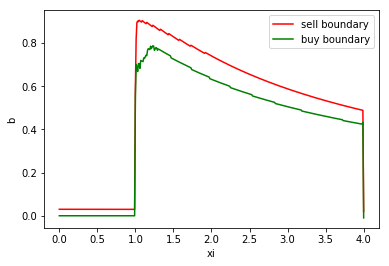

In [39]:
plt.plot(xb,(1-sellboundary)/(sellboundary+(1-tau*(1-xb))*(1-sellboundary)),'r',label='sell boundary')
plt.plot(xb,(1-buyboundary)/(buyboundary+(1-tau*(1-xb))*(1-buyboundary)),'g',label='buy boundary')
plt.legend()
plt.xlabel('xi')
plt.ylabel('b')
plt.show()